In [252]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN



## DATA PRETREATMENT

Importo il dataset 

In [253]:
FFILE = './data_banknote_authentication.txt'
data = pd.read_csv(FFILE, header = None)
data.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Rinomino le colonne del dataset


In [254]:
data = data.rename(columns = {0:'variance',1:'skewness',2:'curtosis',3:'entropy',4:'class'})
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Analisi e confronto variabile 'variance'

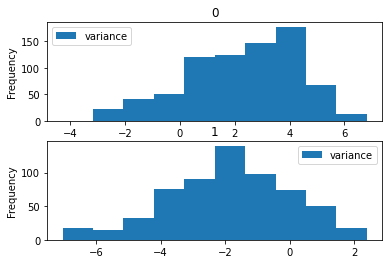

In [255]:
ax = data.plot.hist(column = ['variance'],by = 'class')

In [256]:
data[['class','variance']].groupby('class').mean()


,variance
class,
0,2.276686
1,-1.868443


Analisi e confronto variabile 'skewness'

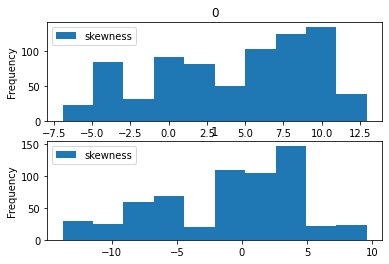

In [257]:
ax = data.plot.hist(column = ['skewness'],by = 'class')

Analisi e confronto variabile 'curtosis'

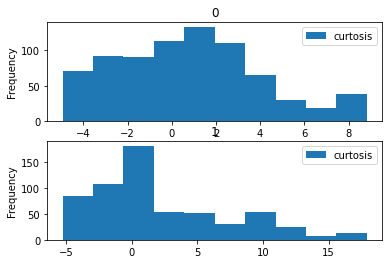

In [258]:
ax = data.plot.hist(column = ['curtosis'],by = 'class')

Analisi e confronto variabile 'entropy'

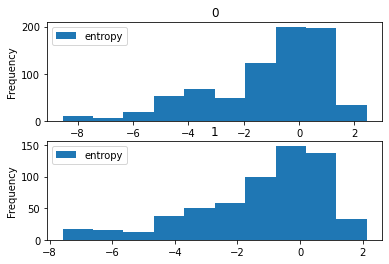

In [259]:
ax = data.plot.hist(column = ['entropy'],by = 'class')

L'entropia è l'unica variabile che non evidenzia sostanziali differenze nella distribuzione. 

### Normalizzazione e shuffle

I dati non necessiterebbero di normalizzazione visto che gli ordini di grandezza delle diverse variabili sono gli stessi. Dovendo però usare PCA in seguito, nel calcolare la matrice di covarianza torna utile avere sottratto la media. La funzione StandardScaler() vista in aula oltre a dividere per la deviazione sottrae anche la media.




L'ordine delle righe nel dataframe è tale per cui le prime righe sono tutte di classe '0' e le successive tutte '1'. Prima di dividere il set in train-set e test-set si fa uno shuffle delle righe.

In [260]:
data = data.sample(frac=1,random_state=3).reset_index(drop=True)

## UNSUPERVISED LEARNING

### PCA

Trasformazione dei dati

In [261]:
X = data.iloc[:,:-1].values
label = data.iloc[:,4].values

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)




In [262]:
Cov = np.matmul(X_scaled.transpose(), X_scaled)
lamb, v = LA.eigh(Cov)  
idx = np.argsort(-lamb)
lambs = lamb[idx]
vs = v[:,idx]
print(lambs)
projection = np.matmul(X_scaled, vs)

[2990.82838913 1774.2085225   482.09669946  240.86638891]


Grafico delle prime due componenti

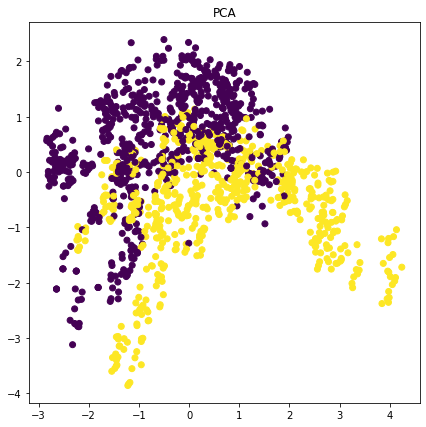

In [263]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(projection[:,0],projection[:,1], c=label)
ax.set_title('PCA')
plt.show()

Non è possibile separare nettamente le due classi linearmente.


Si può confrontare il grafico ottenuto senza PCA, considerando semplicemente le prime due componenti

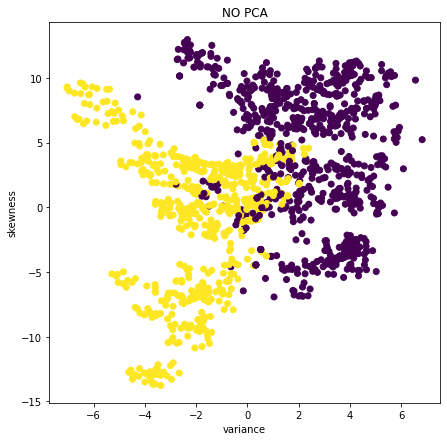

In [264]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(X[:,0],X[:,1], c=label)
ax.set_title('NO PCA')
ax.set_xlabel('variance')
ax.set_ylabel('skewness')
plt.show()

PCA non sembra essere molto d'aiuto, anzi forse nel secondo grafico le due classi sono distinte meglio.

### K-MEANS


In [265]:
def k_means_internal(k, X, init):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset 
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    '''
    N = X.shape[0] # number of points 
    nc = X.shape[1] # number of coordinates
    ll = np.arange(k) 
    z = np.zeros(N, dtype='int') # cluster number assigned to each data point
    cent = np.zeros([k, nc]) # coordinates of the cluster centers
    # k-means++
    if (init=='++'):
        b = np.random.choice(N, 1, replace=False) # choose the first cluster center at random
        cent[0, :] = X[b, :]
        nchosen = 1 # number of cluster centers already set
        while (nchosen < k):
            dist = cdist(cent[:nchosen, :], X) # distance of each point from the cluster centers
            dmin = np.min(dist, axis=0) # min distance btw point and cluster centers
            prob = dmin**2 
            prob = prob/np.sum(prob) 
            # choose next center according to the computed prob
            b = np.random.choice(N, 1, replace=False, p=prob) 
            cent[nchosen, :] = X[b,:]
            nchosen = nchosen + 1
    # random initialization
    else:
        b = np.random.choice(N, k, replace=False)  # choose the k centers randomly 
        for i in ll:
            cent[i, :] = X[b[i],:]
    dist = cdist(cent, X)  # distance of each point from cluster centers 
    z_new = np.argmin(dist, axis=0) # assign each point to cluster with closest center
    dmin = np.min(dist,axis=0)
    niter = 0
    L = np.sum((dmin)**2) # loss function evaluation
    while (z_new != z).any(): # until a stable configuration is reached
        z = np.copy(z_new)
        for i in range(k):
            cent[i, :] = np.average(X[z==i,:],axis=0) # compute cluster centroids
        dist = cdist(cent, X) # update distances from cluster centers
        z_new = np.argmin(dist, axis=0) # find cluster with min centroid distance
        dmin = np.min(dist, axis=0)
        L = np.sum(dmin**2) # loss function evaluation
        niter = niter + 1
    return (z_new, L, niter)

In [266]:
def k_means(k, X, init='++', n_init=20):
    '''
    Parameters
    ----------
    k : int
      Number of clusters
    X : matrix of dimension N x D
      Dataset 
    init : str either '++' or 'random'
      Type of initialization for k-means algorithm
    n_init : int
      Number of runs of the algorithms (with different initializations)
    '''
    lmin = 9.9*10**99
    for i in range(n_init):
        labels, loss, niter = k_means_internal(k, X_scaled, init=init)
        if (loss < lmin):  # store the best performing iteration
            lmin = loss
            labels_opt = labels
    return (labels_opt, lmin)

In [267]:
two_dimension_projection = projection[:,0:2]

In [268]:
k_labels, k_lmin = k_means(2,two_dimension_projection)

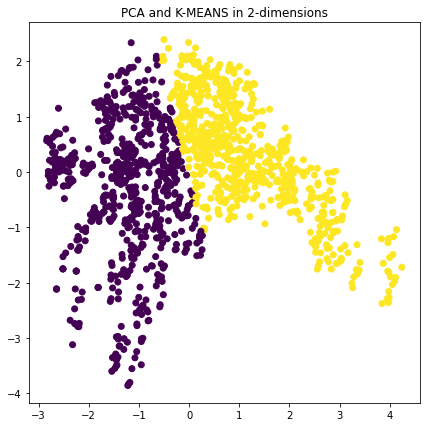

In [269]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(two_dimension_projection[:,0],two_dimension_projection[:,1], c=k_labels)
ax.set_title('PCA and K-MEANS in 2-dimensions')
plt.show()

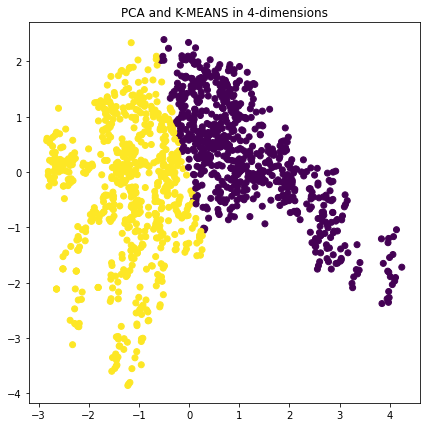

In [270]:
k_labels2, k_lmin2 = k_means(2,projection)
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(projection[:,0],projection[:,1], c=k_labels2)
ax.set_title('PCA and K-MEANS in 4-dimensions')
plt.show()

Il risultato è identico


In [271]:
np.array_equal(k_labels,k_labels2)

False

### T-SNE

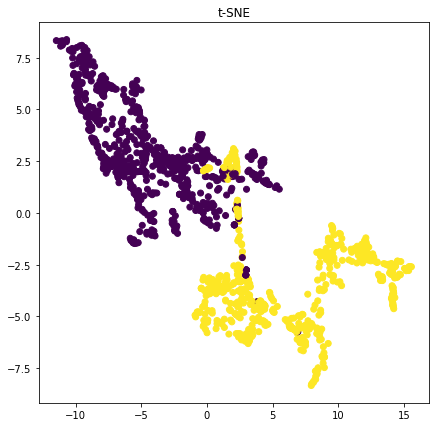

In [272]:
X_embedded = TSNE(n_components=3, learning_rate='auto',
                  init='random', perplexity=50).fit_transform(X_scaled)
fig, ax =plt.subplots(figsize=(7,7))
ax.scatter(X_embedded[:,0],X_embedded[:,1], c=label)
ax.set_title('t-SNE')
plt.show()

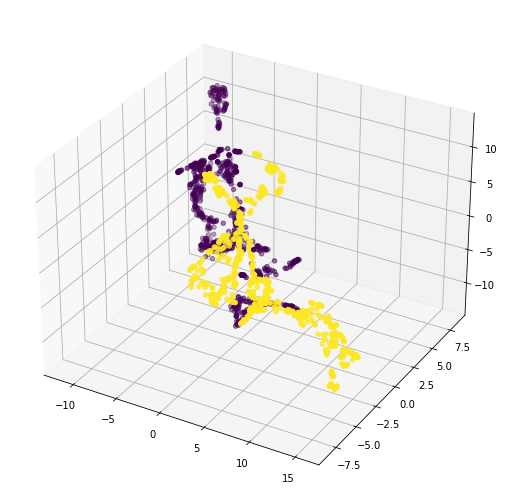

In [273]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_embedded[:,0],X_embedded[:,1], X_embedded[:,2],c=label)
plt.show()

Dopo un pò di tentativi con T-SNE si potrebbero ottenere risultati migliori di PCA. A differenza di PCA non è deterministico. Non sarebbe possibile, ad esempio, replicare i risultati su un altro dataset (mentre nel caso di PCA, una volta calcolata la matrice di covarianza da un dataset e lo spazio delle proiezioni relativo, possiamo proiettare nello stesso spazio i punti di qualsiasi dataset)

### DBSCAN

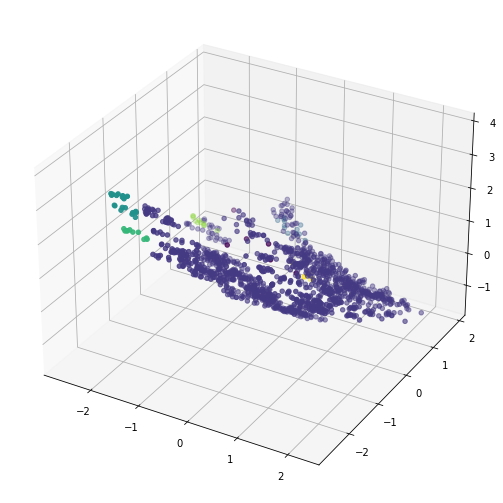

In [274]:
dbscan = DBSCAN(eps=0.6, min_samples=10).fit(X_scaled)

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_scaled[:,0],X_scaled[:,1], X_scaled[:,2],c=dbscan.labels_)
plt.show()

Il clustering con DBSCAN non è efficace. Probabilmente lo sarebbe stato se le due classi nei grafici precedenti fossero distrubuite come due "nuvole" di punti differenti, due cluster ben separati,meno densi via via che ci si sposta da uno all'altro.

## SUPERVISED LEARNING

In [275]:
train_data = data.iloc[372:,:]
test_data = data.iloc[:372:,:]
X_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
X_test = test_data.iloc[:,:-1].values
y_test = test_data.iloc[:,-1].values

### Logistic Regression

Ci sono 2 iperparametri da valutare: alpha e lambda. 



In [276]:
from sklearn.linear_model import LogisticRegression

In [277]:
def KFoldCVRLS(Xtr, ytr, K, lam,alpha,gamma):
    """
    Parameters
    ----------
    Xtr : matrix of float of dim n x d
        Dataset
    Ytr : array of float of dim n
        Ground truth values
    K : int
        Number of folds to split the data into
    lam : array of float 
        Tuning hyperparameter under analysis
    alpha : float
        L1 weight
    gamma : float
        Learning rate
    """
    num_hpar = len(lam) # number of possible values for the hyperparameter
    points = Xtr.shape[0] # total training points
    fold_size = int(np.ceil(points/K)) # size of each K-fold
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_accuracy_mean = np.zeros(num_hpar)
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_std = np.zeros(num_hpar)
    # random permutation of training data
    rand_idx = np.random.choice(points, size=points, replace=False)
    # train and validation loss for each of the K runs for each of the
    # possible hyperparameter values
    
    val_acc = np.zeros((num_hpar,K))
   
    # loop across all hyperparameters values
    for l_idx, l in enumerate(lam): 
        first = 0
        # K-fold CV runs
        for fold in range(K):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points) 
            flags[first:first + fold_size] = 1;  
            
            # construct the  training and validation set      
            X_ = Xtr[rand_idx[flags==0]]
            y_ = ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            y_val = ytr[rand_idx[flags==1]] 

            
            
            model = LogisticRegression(penalty = 'elasticnet',C = 1/l, solver = 'saga', l1_ratio=alpha,max_iter = 10000000, tol = 0.1)
            model.fit(X_,y_)
            predictions = model.predict(X_val)
            
            
           
           
            
            # compute the validation accuracy for the given value of lambda
           
           
            
            val_accuracy = accuracy_score(y_val,predictions)
            
            val_acc[l_idx, fold] = val_accuracy
            
            # update the first position to select the next fold
            first = first + fold_size                

        # summarize performance metrics
        
        val_accuracy_mean[l_idx] = np.mean(val_acc[l_idx,:])
        
       
        val_std[l_idx] = np.std(val_acc[l_idx,:])
    
    best_par_idx = np.argmax(val_accuracy_mean)
    best_par = lam[best_par_idx]

    return best_par, val_accuracy_mean, val_std

In [278]:
alpha_values = np.linspace(0, 1, 5)
lam = np.linspace(0, 10, 11)
best = np.zeros((len(alpha_values)))
gamma = 0.01
K =7



A

In [279]:
np.seterr(divide='ignore')
for i in range(len(alpha_values)):
    best_par, val_mean, val_std =KFoldCVRLS(X_train, y_train, K, lam,alpha_values[i],gamma)
    print(alpha_values[i])
    print(val_mean)
    best[i]=best_par
print(best)
    

0.0
[0.97000183 0.96900283 0.97000183 0.96899579 0.96900283 0.96900283
 0.96899579 0.96699779 0.96900283 0.96900283 0.96799679]
0.25
[0.9690169 0.9700159 0.9700159 0.9670189 0.9690169 0.9680179 0.9690169
 0.9690169 0.9690169 0.9690169 0.9710149]
0.5
[0.96900986 0.97000183 0.96700483 0.96900283 0.96900283 0.97100787
 0.97000886 0.9710149  0.9700159  0.9720139  0.97100787]
0.75
[0.96898876 0.96898876 0.96998776 0.96998776 0.96998776 0.96898876
 0.96699076 0.96798976 0.96798976 0.96899579 0.96898876]
1.0
[0.9690169  0.9700159  0.96900986 0.9680179  0.9700159  0.9690169
 0.9700159  0.9690169  0.9690169  0.9710149  0.9730129 ]
[ 0. 10.  9.  2. 10.]


### KNN


In [280]:
from scipy.spatial.distance import euclidean

def distance(point_one, point_two):
    return euclidean(point_one, point_two)

def get_neighbors(train_set, test_point, label_col, n_neighbors):
  dist = np.array([distance(train_point, test_point) for train_point in train_set])
  idx_dist = dist.argsort()
  ordered_train = train_set[idx_dist, :]
  ordered_label = label_col[idx_dist]
  return ordered_train[:n_neighbors], ordered_label[:n_neighbors]

def predict(train_set, test_point, labels, n_neighbors):
  neigh, neigh_label = get_neighbors(train_set, test_point, labels, n_neighbors)
  values, counts = np.unique(neigh_label, return_counts=True)
  idx = np.argmax(counts)
  return values[idx]

def evaluate(train_set, test_set, label, n_neighbors=2):
    correct_preditct = 0
    wrong_preditct = 0
    train_labels = train_set[label].values
    train_set = train_set.drop(label, axis=1)
    test_labels = test_set[label].values
    test_set = test_set.drop(label, axis=1)
    for index in range(len(test_set.index)):  # for each row in the dataset
        result = predict(train_set.values, test_set.iloc[index].values, train_labels, n_neighbors)  # predict the row
        if result == test_labels[index]:  # predicted value and expected value is same or not
            correct_preditct += 1  # increase correct count
        else:
            wrong_preditct += 1  # increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)  # calculating accuracy
    return accuracy

In [281]:


predictions_knn = np.zeros(test_data.shape[0])
for j in range(test_data.shape[0]):

    predictions_knn[j]=predict(train_data.iloc[:,:-1].values,test_data.iloc[j,:-1].values,train_data.iloc[:,-1].values,2)



Attraverso la K-fold Cross Validation si sceglie il miglior valore di K.

In [282]:
def KFoldCVKNN(dataset, K_folds, K, classe):
    """
    Parameters
    ----------
    dataset : matrix of dim n x d
        Dataset
    K_folds : int
        Number of folds to split the data into
    K : array of int
        Tuning hyperparameter under analysis

    """
    num_hpar = len(K) # number of possible values for the hyperparameter
    points = dataset.shape[0] # total training points
    fold_size = int(np.ceil(points/K_folds)) # size of each K-fold
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_accuracy_mean = np.zeros(num_hpar)
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_std = np.zeros(num_hpar)
    # random permutation of training data
    rand_idx = np.random.choice(points, size=points, replace=False)
    
    
    val_acc = np.zeros((num_hpar,K_folds))
   
    # loop across all hyperparameters values
    for l_idx, l in enumerate(K): 
        print(l)
        first = 0
        # K-fold CV runs
        for fold in range(K_folds):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points) 
            flags[first:first + fold_size] = 1;  
            
            # construct the  training and validation set      
            X_ = dataset.iloc[rand_idx[flags==0]]
            
            X_val = dataset.iloc[rand_idx[flags==1]]
                            
            
            # compute the accuracy
            
                                  
            val_accuracy = evaluate(X_,X_val,classe)
            
            
            val_acc[l_idx, fold] = val_accuracy
            
            # update the first position to select the next fold
            first = first + fold_size 
            

        # summarize performance metrics
        
        val_accuracy_mean[l_idx] = np.mean(val_acc[l_idx,:])
        
        print(val_accuracy_mean[l_idx])
        
       
        val_std[l_idx] = np.std(val_acc[l_idx,:])
    
    best_par_idx = np.argmax(val_accuracy_mean)
    best_par = K[best_par_idx]

    return best_par, val_accuracy_mean, val_std

In [283]:
K = [2,3,5,7,9]
bestpar,valacc,valstd = KFoldCVKNN(train_data,5, K,'class')
bestpar


2
1.0
3
1.0
5
1.0
7
1.0
9
1.0


2

### GAUSSIAN NAIVE BAYES

Supponiamo che i dati siano distribuiti secondo una gaussiana


In [284]:
def prior(train_data, label):
  priors = train_data.groupby(by=label).apply(lambda x: len(x)/len(train_data))
  return np.log(priors).values

def mean_variance(train_data, label):
  mean = train_data.groupby(by=label).apply(lambda x: x.mean(axis=0))
  variance = train_data.groupby(by=label).apply(lambda x: x.var(axis=0))
  return (mean.values, variance.values)

def gaussian_density(mean, variance, point):
  d = (1 / np.sqrt(2*np.pi*variance)) * np.exp((-(point - mean)**2) / (2*variance))
  return d

def train_gaussian_naive_bayes(train_data, label):
  mean, variance = mean_variance(train_data, label)
  priors = prior(train_data, label)
  unique_labels = train_data[label].unique()
  n_labels = len(unique_labels)
  return {'n_labels': n_labels, 'unique_labels': unique_labels, 'n_classes': n_labels, 'mean': mean, 
          'variance': variance, 'prior': priors}
    

In [285]:
def posterior(point, mean, variance, class_list, n_classes, n_feat):
  posteriors = []
  for i in range(n_classes):
    posterior = 0
    for j in range(n_feat):
      posterior += np.log(gaussian_density(mean[i][j], variance[i][j], point[j]))
    posteriors.append(posterior)
  return posteriors

def predict(test_data, label, gaus_bayes):
  predictions = []
  n_feat = len(test_data.columns) - 1
  for i in range(len(test_data)):
    pr = gaus_bayes['prior']
    post = posterior(test_data.iloc[i, :-1], gaus_bayes['mean'], gaus_bayes['variance'], 
                     gaus_bayes['unique_labels'], gaus_bayes['n_classes'], n_feat)
    prob = pr + post
    max_prob_class_idx = np.argmax(prob)
    predictions.append(gaus_bayes['unique_labels'][max_prob_class_idx])
  return predictions 

def evaluate(test_data, label, gaus_bayes):
  gaus_pred = predict(test_data, label, gaus_bayes)
  correct_predict = 0
  wrong_predict = 0
  for index in range(len(test_data.index)):  # for each row in the dataset
        if gaus_pred[index] == test_data[label].iloc[index]:  # predicted value and expected value is same or not
            correct_predict += 1  # increase correct count
        else:
            wrong_predict += 1  # increase incorrect count
  accuracy = correct_predict / (correct_predict + wrong_predict)  # calculating accuracy
  return accuracy
     

In [286]:
gaus_bayes = train_gaussian_naive_bayes(train_data, 'class')

In [287]:
evaluate(test_data,'class',gaus_bayes)

0.8467741935483871

Il valore di accuracy ottenuto sembra molto alto, ma confrontando i risultati con altre persone c'è il sospetto che dipenda molto dal dataset di training. Se infatti come test_data si scelgono le ultime 372 righe invece che le prime il valore di accuracy sta sotto il 20%

Si può valutare come variano i risultati in base al dataset di training con la cross-validation.
Nota che in questo caso non cerchiamo di settare un iperparametro come nei casi precedenti. Ora si cerca di valutare la sensibilità delle performance del modello 
sulla base dei dati iniziali. Basta un K di 2 o 3

In [288]:
def KFoldBayes(train,K,label):
    """
    Parameters
    ----------
    train: matrix of dim n x d
        Dataset
    K: int
        Number of folds to split the dataset into
    """
    points = train.shape[0]
    fold_size = int(np.ceil(points/K))
    rand_idx = np.random.choice(points, size=points, replace=False)
    results = np.zeros(K)
    
    first = 0
    for fold in range(K):
        flags = np.zeros(points) 
        flags[first:first + fold_size] = 1; 
        X = train.iloc[rand_idx[flags==0]]
        X_val = train.iloc[rand_idx[flags==1]]
        bayes_model = train_gaussian_naive_bayes(X, label)
        results[fold]=evaluate(X_val,label,bayes_model)
        
        first = first + fold_size
    return results
    

In [289]:
res_k = KFoldBayes(train_data,5,'class')
res_k

array([0.82 , 0.84 , 0.85 , 0.835, 0.84 ])

I valori sono altalenanti...come mai? Un'idea è che i dati non si distribuiscano come una gaussiana, cosa che assuamiamo nel modello. Effettivamente gli istogrammi hanno una forma non a campana

### DECISION TREE

In [290]:
# compute H(S)
def entropy(train_data, label, class_list):
    total_row = train_data.shape[0]  # the total size of the dataset  
    total_entr = 0
    for c in class_list:  # for each possible class in the label
        total_class_count = train_data[train_data[label] == c].shape[0]  # number of points belonging to the class
        if total_class_count > 0:
          total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row)  # entropy of the class
          total_entr += total_class_entr  # adding the class entropy to the total entropy of the dataset
    return total_entr

# compute H(S_j)
def feature_entropy(left_data, right_data, label, class_list):
    row_count = left_data.shape[0] + right_data.shape[0] # n points considered
    p_left = left_data.shape[0] / row_count
    p_right = right_data.shape[0] / row_count
    ent = p_left * entropy(left_data, label, class_list) + p_right * entropy(right_data, label, class_list)
    return ent

def split(feature_column, threshold):
  left_rows = np.argwhere(feature_column <= threshold).flatten()
  right_rows = np.argwhere(feature_column > threshold).flatten()
  return left_rows, right_rows


def information_gain(data, feature_name, label, class_list, threshold):
  left_rows, right_rows = split(data[feature_name].values, threshold)
  if len(left_rows)==0 or len(right_rows)==0:
    return 0
  feat_entropy = feature_entropy(data.iloc[left_rows], data.iloc[right_rows], label, class_list)
  return feat_entropy

def get_split_thresholds(feature_column, n_thresholds):
  feature_column = feature_column.values
  n_data = len(feature_column)
  sorted_column = np.sort(feature_column)
  if len(feature_column) > 1:
    partitioned_array = np.array_split(feature_column, n_thresholds + 1)
    thresholds = [(partitioned_array[i][-1] + partitioned_array[i+1][0])/2 for i in range(len(partitioned_array)-1)]
  else:
    thresholds = [feature_column[0]]
  return thresholds

def most_informative_feature(train_data, label, class_list, n_thresholds):
    feature_list = train_data.columns.drop(label)
    min_entropy = 99999
    min_entropy_feature = None
    min_entropy_threshold = None
    for feature in feature_list:
      thresholds = get_split_thresholds(train_data[feature], n_thresholds)
      for t in thresholds:
        info_gain = information_gain(train_data, feature, label, class_list, t)
        if info_gain < min_entropy:
          min_entropy = info_gain
          min_entropy_feature = feature
          min_entropy_threshold = t
    return min_entropy_feature, min_entropy_threshold

def is_leaf(train_data, label):
  classes_in_node = np.unique(train_data[label])
  if len(classes_in_node) == 1:
    return True
  else:
    return False

def leaf_class(train_data, label):
    class_list, count_class = np.unique(train_data[label], return_counts=True)
    idx = count_class.argmax()
    return class_list[idx]
     
def make_tree(train_data, label, class_list, n_thresholds, cur_depth, min_samples, max_depth):
  if is_leaf(data, label) or cur_depth>=max_depth or len(train_data)<=min_samples:
    return leaf_class(train_data, label)
  else:
    cur_depth += 1
    split_feature, split_threshold = most_informative_feature(train_data, label, class_list, n_thresholds)
    left_rows, right_rows = split(train_data[split_feature].values, split_threshold)
    if len(left_rows)==0 or len(right_rows)==0:
      return leaf_class(train_data, label)
    else:
      # build sub tree
      split_condition = "{} <= {}".format(split_feature, split_threshold)
      sub_tree = {split_condition : []}
      # recursive call
      left_branch = make_tree(train_data.iloc[left_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
      right_branch = make_tree(train_data.iloc[right_rows], label, class_list, n_thresholds, cur_depth, min_samples, max_depth)
      if left_branch == right_branch:
        sub_tree = left_branch
      else:
        # grow the tree
        sub_tree[split_condition].append(left_branch)
        sub_tree[split_condition].append(right_branch)
      return sub_tree

def id3(train_data_m, label, n_thresholds=1, min_samples=4, max_depth=6):
    train_data = train_data_m.copy()  # getting a copy of the dataset
    class_list = train_data[label].unique()  # getting unqiue classes of the label
    tree = make_tree(train_data, label, class_list, n_thresholds, 0, min_samples, max_depth)  # start calling recursion
    return tree

def predict(test_point, tree):
    if not isinstance(tree, dict):
      return tree
    question = list(tree.keys())[0]
    attribute, value = question.split(" <= ")
    if test_point[attribute] <= float(value):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
    return predict(test_point, answer)

def evaluate(tree, test_data, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index in range(len(test_data.index)):  # for each row in the dataset
        result = predict(test_data.iloc[index], tree)  # predict the row
        if result == test_data[label].iloc[index]:  # predicted value and expected value is same or not
            correct_preditct += 1  # increase correct count
        else:
            wrong_preditct += 1  # increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct)  # calculating accuracy
    return accuracy


In [291]:
t = id3(train_data, 'class')
print(t)

{'variance <= -3.30365': [1, {'variance <= 1.6227999999999998': [{'skewness <= 8.40955': [{'variance <= -2.68935': [1, {'variance <= -1.4839900000000001': [1, {'curtosis <= -1.4577499999999999': [1, 0]}]}]}, 0]}, {'curtosis <= -3.91305': [{'variance <= 3.0803000000000003': [1, 0]}, 0]}]}]}


In [292]:
def KFoldCVIDT(dataset, K_folds, depth, classe):
    """
    Parameters
    ----------
    dataset : matrix of dim n x d
        Dataset
    K_folds : int
        Number of folds to split the data into
    depth : array of int
        Tuning hyperparameter under analysis

    """
    num_hpar = len(depth) # number of possible values for the hyperparameter
    points = dataset.shape[0] # total training points
    fold_size = int(np.ceil(points/K_folds)) # size of each K-fold
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_accuracy_mean = np.zeros(num_hpar)
    # array containing the mean and std of the accuracy for each 
    # hyperparameter accross all K runs of CV
    
    val_std = np.zeros(num_hpar)
    # random permutation of training data
    rand_idx = np.random.choice(points, size=points, replace=False)
    
    
    val_acc = np.zeros((num_hpar,K_folds))
   
    # loop across all hyperparameters values
    for l_idx, l in enumerate(depth): 
        print(l)
        first = 0
        # K-fold CV runs
        for fold in range(K_folds):
            # create a mask to distinguish train and validation set for this run
            flags = np.zeros(points) 
            flags[first:first + fold_size] = 1;  
            
            # construct the  training and validation set      
            X_ = dataset.iloc[rand_idx[flags==0]]
            
            X_val = dataset.iloc[rand_idx[flags==1]]
                            
            
            # compute the accuracy
            
            t_model = id3(train_data, 'class',max_depth = l)                     
            val_accuracy = evaluate(t_model,X_val,classe)
            
            
            val_acc[l_idx, fold] = val_accuracy
            
            # update the first position to select the next fold
            first = first + fold_size 
            

        # summarize performance metrics
        print(val_acc[l_idx,:])
        val_accuracy_mean[l_idx] = np.mean(val_acc[l_idx,:])
        
        print(val_accuracy_mean[l_idx])
        
       
        val_std[l_idx] = np.std(val_acc[l_idx,:])
    
    best_par_idx = np.argmax(val_accuracy_mean)
    best_par = depth[best_par_idx]

    return best_par, val_accuracy_mean, val_std

In [293]:
depth = [5,6,7,8,9,10,11,12,13]
K_folds = 5


In [294]:
b,accmean,valstd = KFoldCVIDT(train_data, K_folds, depth, 'class')

5
[0.875 0.89  0.88  0.875 0.875]
0.8789999999999999
6
[0.9   0.93  0.91  0.825 0.89 ]
0.891
7
[0.96  0.975 0.97  0.925 0.94 ]
0.954
8
[0.96  0.975 0.97  0.935 0.94 ]
0.9560000000000001
9
[0.96 0.97 0.97 0.93 0.97]
0.96
10
[0.99  0.99  0.995 0.975 0.99 ]
0.9880000000000001
11
[0.995 0.995 0.995 0.985 0.995]
0.993
12
[0.995 0.995 0.995 0.99  0.995]
0.994
13
[0.995 0.995 0.995 0.99  0.995]
0.994


### COMPARISON




In [295]:
from sklearn.metrics import classification_report


Non viene preso in considerazione Gaussian Naive Bayes perchè è il peggiore 

Per primo si valuta l' ID3

In [296]:
t = id3(train_data, 'class',max_depth = 12)
predictions = np.zeros(test_data.shape[0])
for index in range(test_data.shape[0]):

    predictions[index]=predict(test_data.iloc[index,:-1],t)


In [297]:
print(classification_report(y_test, predictions))
      


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       218
           1       0.98      0.97      0.98       154

    accuracy                           0.98       372
   macro avg       0.98      0.98      0.98       372
weighted avg       0.98      0.98      0.98       372



Valutazione della Logistic Regression

In [298]:
model = LogisticRegression(None)
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       218
           1       1.00      0.99      0.99       154

    accuracy                           0.99       372
   macro avg       1.00      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



Valutazione KNN


In [299]:
print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       218
           1       1.00      1.00      1.00       154

    accuracy                           1.00       372
   macro avg       1.00      1.00      1.00       372
weighted avg       1.00      1.00      1.00       372

